## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
#%%bash
#ls

In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj, dataset_in_memory, check_datasets
from LOW_LEVEL_UTILITIES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_decay_p_factor
from simulation_dictionary import SimulationDictionary 
from VAE.vae_model import Compositional_VAE

import numpy as np
import torch
import pyro
from pyro.infer import SVI, TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 
from pyro.optim import Adam, Adamax, SGD, RMSprop

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Get the data

In [4]:
#disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"
#mMNIST_data_dir = "/home/ldalessi/DATA/MULTI_MNIST/"
mMNIST_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_MNIST/"
fashion_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_FashionMNIST/"
real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v4/"
real_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/REAL_DAPI_V4/"

train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_train_large_hard",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_test_large_hard",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=torch.cuda.is_available())

Dataset lenght: 1688
imgs.shape torch.Size([8, 1, 128, 128])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


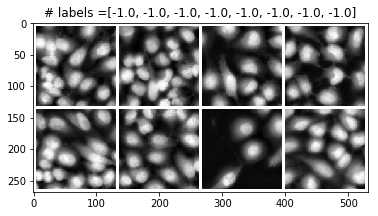

In [5]:
check_datasets(train_dataset)

Dataset lenght: 296
imgs.shape torch.Size([8, 1, 128, 128])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


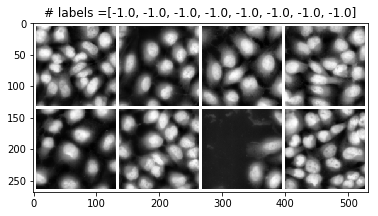

In [6]:
check_datasets(test_dataset)

tensor(-1., device='cuda:0')


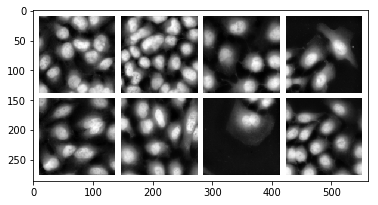

In [7]:
imgs_in, labels = train_dataset.load(8)
print(labels[0])
show_batch(imgs_in)

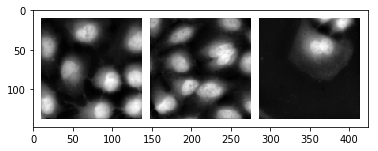

In [8]:
show_batch(imgs_in[2:-1:2])

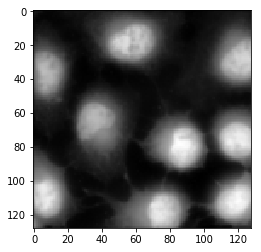

In [9]:
show_batch(imgs_in[2:3])

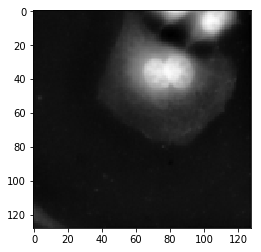

In [10]:
show_batch(imgs_in[-2:-1])

Text(0.5, 0, 'pixel intensity')

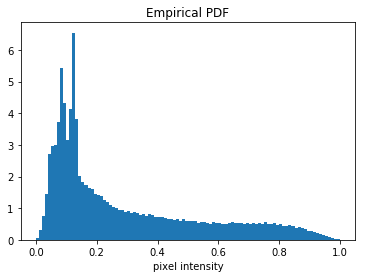

In [11]:
b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("pixel intensity")

Text(0.5, 0, 'Average intensity in box of size 15')

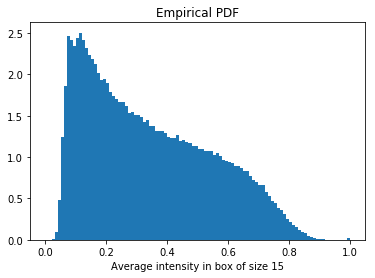

In [12]:
size=15
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

Text(0.5, 0, 'Average intensity in box of size 35')

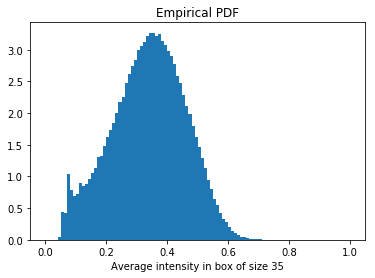

In [13]:
size=35
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

# Generate the names

In [14]:
write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/buckets/VAE-ARCHIVE/'

descriptor        = "DAPI_sigma_each_object_t4_v03"
#descriptor        = "FASHION_unit_cauchy_t4_v3"
#descriptor        = "MNIST_unit_cauchy_t4_v4"
#descriptor        = "DISK_v4"
#descriptor        = "DISK_speed"
name_vae          = descriptor+"_vae"
name_history      = descriptor+"_hystory"
name_hyper_params = descriptor+"_hyper_params"
epoch_restart     = 80
from_scratch = True


if(from_scratch):
    epoch_restart     = -1
    hyper_params=SimulationDictionary()
    hyper_params.check_consistency()
    print(hyper_params)
    
    min_loss = 99999999
    history_dict = {
        "train_loss" : [],
        "test_loss" : [],
        "fg_mu" : [],
        "bg_mu" : [],
        "fg_sigma" : [],
        "bg_sigma" : [],
        #"normal_sigma" : [],
        "std_bx_dimfull" : [],
        "std_by_dimfull" : [],
        "std_bw_dimfull" : [],
        "std_bh_dimfull" : []
        }
    
    vae = Compositional_VAE(hyper_params)
    vae.reset()
    
else:
    hyper_params = load_obj(write_dir,name_hyper_params+"_"+str(epoch_restart))
    hyper_params.check_consistency()
    print(hyper_params)
    history_dict = load_obj(write_dir,name_history+"_"+str(epoch_restart))
    min_loss = min(history_dict["test_loss"])
    vae = Compositional_VAE.load(hyper_params,write_dir,name_vae+"_"+str(epoch_restart))

save_obj(hyper_params,write_dir,name_hyper_params+"_write_test")

{'SD.dim_h2': -1, 'REGULARIZATION.lambda_small_box_size': 0.0, 'REGULARIZATION.min_volume_mask': 0.0, 'SD.width': 28, 'IMG.ch_in_description': ['DAPI'], 'UNET.N_up_conv': 2, 'PRIOR.width_zwhat': 0.005, 'REGULARIZATION.lambda_overlap': 0.0, 'ZWHAT.dim': 50, 'ZMASK.dim': 50, 'PRIOR.expected_object_size': 20, 'use_cuda': True, 'PRIOR.width_zmask': 0.005, 'REGULARIZATION.lambda_mask_volume_absolute': 1.0, 'NMS.p_threshold': 0.0, 'PRIOR.min_object_size': 10, 'REGULARIZATION.lambda_mask_volume_fraction': 1.0, 'IMG.size_raw_image': 80, 'REGULARIZATION.max_volume_mask': 500.0, 'REGULARIZATION.lambda_tot_var_mask': 1.0, 'UNET.N_max_pool': 4, 'REGULARIZATION.LOSS_ZWHAT': 10.0, 'REGULARIZATION.p_corr_factor': 0.0, 'REGULARIZATION.LOSS_ZMASK': 10.0, 'PRIOR.max_object_size': 40, 'UNET.N_prediction_maps': 1, 'SD.dim_h1': -1, 'NMS.overlap_threshold': 0.2, 'PRIOR.n_max_objects': 30, 'REGULARIZATION.expected_volume_mask': 300.0, 'UNET.CH_after_first_two_conv': 32}
reset ->  Conv2d(1, 32, kernel_size=(3

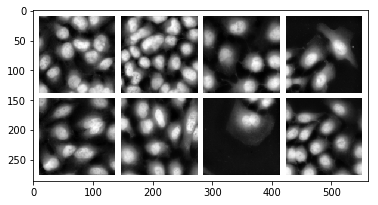

In [15]:
show_batch(imgs_in)

At layer l=  0  we have w_h_j_rf_wloc_hloc=  0 (128, 128, 1, 1, 0.5, 0.5)
At layer l=  1  we have w_h_j_rf_wloc_hloc=  1 (128, 128, 1.0, 5, 0.5, 0.5)
At layer l=  2  we have w_h_j_rf_wloc_hloc=  2 (64, 64, 2.0, 6, 1.0, 1.0)
At layer l=  3  we have w_h_j_rf_wloc_hloc=  3 (64, 64, 2.0, 14, 1.0, 1.0)
At layer l=  4  we have w_h_j_rf_wloc_hloc=  4 (32, 32, 4.0, 16, 2.0, 2.0)
At layer l=  5  we have w_h_j_rf_wloc_hloc=  5 (32, 32, 4.0, 32, 2.0, 2.0)
At layer l=  6  we have w_h_j_rf_wloc_hloc=  6 (16, 16, 8.0, 36, 4.0, 4.0)
At layer l=  7  we have w_h_j_rf_wloc_hloc=  7 (16, 16, 8.0, 68, 4.0, 4.0)
At layer l=  8  we have w_h_j_rf_wloc_hloc=  8 (8, 8, 16.0, 76, 8.0, 8.0)
At layer l=  9  we have w_h_j_rf_wloc_hloc=  9 (8, 8, 16.0, 140, 8.0, 8.0)
At layer l=  10  we have w_h_j_rf_wloc_hloc=  10 (16, 16, 8.0, 156, 4.0, 4.0)
At layer l=  11  we have w_h_j_rf_wloc_hloc=  11 (16, 16, 8.0, 188, 4.0, 4.0)
At layer l=  12  we have w_h_j_rf_wloc_hloc=  12 (32, 32, 4.0, 196, 2.0, 2.0)
At layer l=  13  w

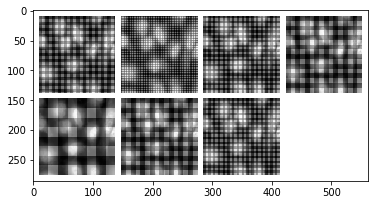

In [16]:
vae.inference.unet.describe_receptive_field(imgs_in)
img_with_grid = vae.inference.unet.show_grid(imgs_in)
print(img_with_grid.shape)
show_batch(img_with_grid[5])

In [17]:
#putative_imgs,putative_masks,background,c = vae.model()
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)
#print("max(putative_imgs)",torch.max(putative_imgs))

In [18]:
#show_batch(background)

In [19]:
#show_batch(putative_imgs[0])

In [20]:
#show_batch(putative_masks[0])
#print(torch.min(putative_masks),torch.max(putative_masks))

In [21]:
#imgs_prior = vae.generate_synthetic_data(N=2)
#show_batch(imgs_prior[:8,:1,:,:])
#print("imgs_prior.shape",imgs_prior.shape)
#print("type(imgs_prior)",type(imgs_prior))
#print("imgs_prior.device",imgs_prior.device)
#print("torch.max(imgs_prior)",torch.max(imgs_prior))
#print("torch.min(imgs_prior)",torch.min(imgs_prior))

In [22]:
#putative_imgs,putative_masks,background,c = vae.model(imgs_prior.cuda())
##putative_imgs,pixel_weights,background,c = vae.model(imgs_prior)
#
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)

In [23]:
#rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(imgs_prior,True)
#
#print("rec_img.shape",rec_img.shape)
#print("min, max of rec_img)",torch.min(rec_img),torch.max(rec_img))
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("logp.logp_off.shape",logp.logp_off.shape)
#print("logp.logp_on_cauchy.shape",logp.logp_on_cauchy.shape)
#print("logp.logp_on_normal.shape",logp.logp_on_normal.shape)
#print("reg.small_box_size.shape",reg.small_box_size.shape)
#print("reg.big_mask_volume.shape",reg.big_mask_volume.shape)
#print("reg.tot_var_mask.shape",reg.tot_var_mask.shape)
#print("reg.overlap_mask.shape",reg.overlap_mask.shape)
#show_batch(rec_img[:8,:,:,:])

### Debug model and guide

In [24]:
#print("TEST SAMPLE")
#test_model(vae.model, 
#           vae.guide, TraceGraph_ELBO())
#
#print("TEST PARALLEL ENUM")
#test_model(vae.model, 
#           config_enumerate(vae.guide, "parallel"), 
#           TraceEnum_ELBO(max_plate_nesting=2))

## Global parameters

In [25]:
TEST_FREQUENCY = 5
WRITE_FREQUENCY = 5
smoke_test= False
if(smoke_test):
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 6 
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 141
    
# batch size
batch_size = 50
decay_lenght_scale = 40

# setup the optimizer
optimizer = Adam({"lr": 1.0e-3})
#optimizer = RMSprop({"lr": 1.0e-4})

svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))

# Actual train loop

In [26]:
# training loop
#epoch_restart = 100
#for delta_epoch in range(1,-1):

for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
   
    vae.p_corr_factor = linear_decay_p_factor(epoch,decay_lenght_scale)

    vae.train()       
    vae.randomize_score_nms = False
    
    print("epoch,vae.p_corr_factor",epoch,vae.p_corr_factor)
    loss = train_one_epoch(svi, train_dataset, epoch, batch_size, verbose=(delta_epoch==1))
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
                
    history_dict["train_loss"].append(loss)
    try:
        history_dict["fg_mu"].append(pyro.param("fg_mu").item())
        history_dict["bg_mu"].append(pyro.param("bg_mu").item())
        history_dict["fg_sigma"].append(pyro.param("fg_sigma").item())
        history_dict["bg_sigma"].append(pyro.param("bg_sigma").item())
        #history_dict["normal_sigma"].append(pyro.param("normal_sigma").item())
        history_dict["std_bx_dimfull"].append(pyro.param("std_bx_dimfull").item())
        history_dict["std_by_dimfull"].append(pyro.param("std_by_dimfull").item())
        history_dict["std_bw_dimfull"].append(pyro.param("std_bw_dimfull").item())
        history_dict["std_bh_dimfull"].append(pyro.param("std_bh_dimfull").item())
    except:
        pass
            
    if(epoch % TEST_FREQUENCY == 0):      
        vae.eval()
        vae.randomize_score_nms = False
        
        loss = evaluate_one_epoch(svi, test_dataset, epoch, batch_size, verbose=(delta_epoch==1))        
        history_dict["test_loss"].append(loss)
            
        if(loss < min_loss):
            min_loss = loss
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
                
        if((loss == min_loss) or ((epoch % WRITE_FREQUENCY) == 0)):   
            # Save on disk
            vae.save_everything(write_dir,name_vae+"_"+str(epoch))
            save_obj(history_dict,write_dir,name_history+"_"+str(epoch))
            save_obj(hyper_params,write_dir,name_hyper_params+"_"+str(epoch))

epoch,vae.p_corr_factor 0 0.5
i=   0 train_loss=498751168.00000
i=   1 train_loss=424689888.00000
i=   2 train_loss=267416928.00000
i=   3 train_loss=124407312.00000
i=   4 train_loss=37004040.00000
i=   5 train_loss=50115384.00000
i=   6 train_loss=52987852.00000
i=   7 train_loss=38537828.00000
i=   8 train_loss=42625496.00000
i=   9 train_loss=27786266.00000
i=  10 train_loss=19276600.00000
i=  11 train_loss=23940176.00000
i=  12 train_loss=18703142.00000
i=  13 train_loss=12319713.00000
i=  14 train_loss=9547217.00000
i=  15 train_loss=8847548.00000
i=  16 train_loss=9705522.00000
i=  17 train_loss=7072037.00000
i=  18 train_loss=4795381.50000
i=  19 train_loss=2562178.50000
i=  20 train_loss=2076118.75000
i=  21 train_loss=3111520.00000
i=  22 train_loss=565307.93750
i=  23 train_loss=1542533.75000
i=  24 train_loss=2245862.00000
i=  25 train_loss=1960065.25000
i=  26 train_loss=1567127.62500
i=  27 train_loss=801761.31250
i=  28 train_loss=6511.38281
i=  29 train_loss=790305.1875

# Check the results

In [27]:
print(history_dict["train_loss"][-5:])
print(history_dict["test_loss"][-5:])
print(history_dict["bg_mu"][-5:])
print(history_dict["fg_mu"][-5:])
print(history_dict["bg_sigma"][-5:])
print(history_dict["fg_sigma"][-5:])
#print(history_dict["normal_sigma"][-5:])
print(history_dict["std_bx_dimfull"][-5:])
print(history_dict["std_by_dimfull"][-5:])
print(history_dict["std_bw_dimfull"][-5:])
print(history_dict["std_bh_dimfull"][-5:])

[-279502.9987878788, -279039.1248484849, -279398.52, -275963.82727272727, -276468.73515151517]
[-266055.172, -265955.732, -260020.428, -262620.436, -253075.916]
[0.09824053198099136, 0.09816943109035492, 0.09776407480239868, 0.09789981693029404, 0.0979013741016388]
[0.5594973564147949, 0.5596996545791626, 0.5601454377174377, 0.5595240592956543, 0.5576853156089783]
[0.07185766100883484, 0.07179893553256989, 0.0716170072555542, 0.07142171263694763, 0.07136648148298264]
[0.2411714494228363, 0.24131713807582855, 0.24145087599754333, 0.24158445000648499, 0.24172912538051605]
[0.11375203728675842, 0.11345177888870239, 0.1131843701004982, 0.11294052004814148, 0.11268240213394165]
[0.11395446211099625, 0.11365155875682831, 0.11337677389383316, 0.11312558501958847, 0.11285829544067383]
[0.12978388369083405, 0.12918376922607422, 0.12865926325321198, 0.12817521393299103, 0.12766242027282715]
[0.12783686816692352, 0.12732122838497162, 0.12684565782546997, 0.12639360129833221, 0.12593448162078857]


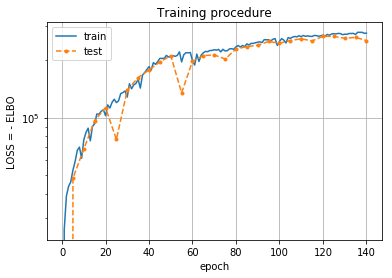

In [28]:
plt.yscale('log')
y_shift=0
x_shift=0
sign = -1.0
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"]), TEST_FREQUENCY), sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
#plt.ylim(top=100000)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'_train.png')

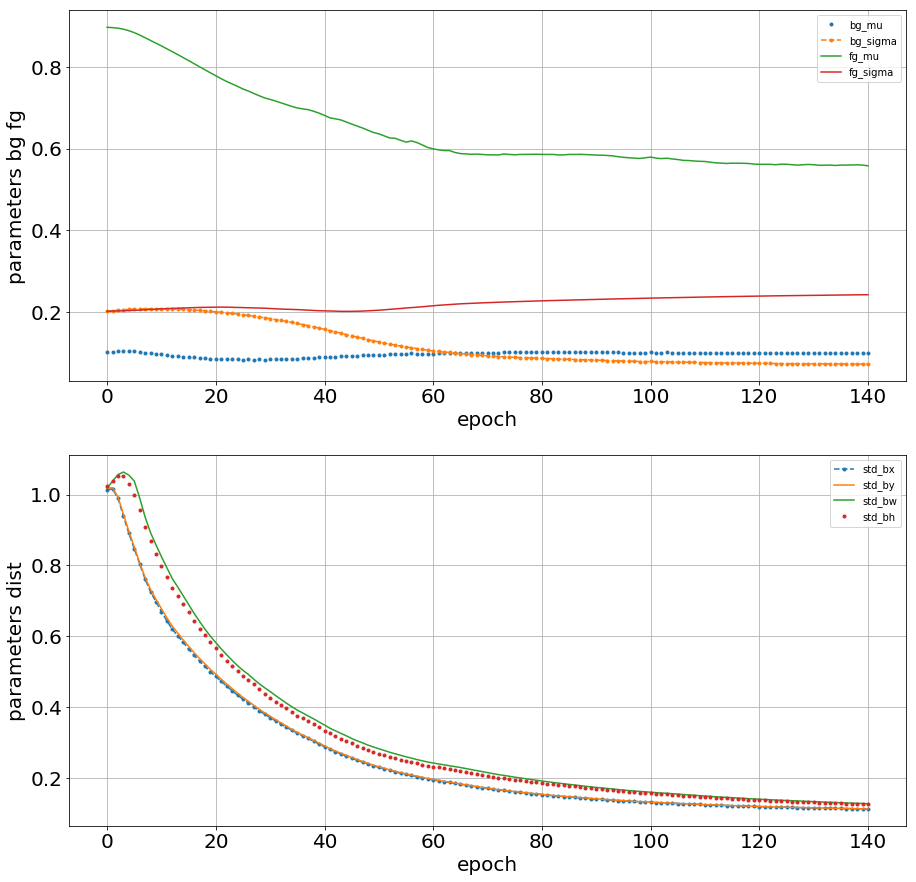

In [29]:
# Create a plot with the priors
fontsize=20
labelsize=20
fig, axs = plt.subplots(2,1, figsize=(15,15))
        
axs[0].set_xlabel('epoch',fontsize=fontsize)
axs[0].set_ylabel('parameters bg fg',fontsize=fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=labelsize)
axs[0].plot(history_dict["bg_mu"],'.')
axs[0].plot(history_dict["bg_sigma"],'.--')
axs[0].plot(history_dict["fg_mu"],'-')
axs[0].plot(history_dict["fg_sigma"],'-')
#axs[0].plot(history_dict["normal_sigma"],'.')
axs[0].legend(['bg_mu','bg_sigma','fg_mu','fg_sigma']) #,'normal_sigma'])
axs[0].grid(True)
        
axs[1].set_xlabel('epoch',fontsize=fontsize)
axs[1].set_ylabel('parameters dist',fontsize=fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].plot(history_dict["std_bx_dimfull"],'.--')
axs[1].plot(history_dict["std_by_dimfull"],'-')
axs[1].plot(history_dict["std_bw_dimfull"],'-')
axs[1].plot(history_dict["std_bh_dimfull"],'.')
axs[1].legend(['std_bx','std_by','std_bw', 'std_bh'])
axs[1].grid(True)
              
fig.savefig(write_dir+name_vae+'_hystory.png')

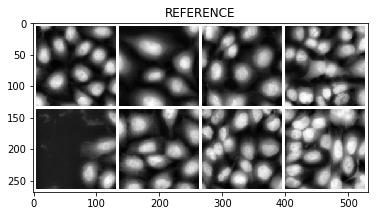

In [30]:
from matplotlib import pyplot as mp

reference_dir = '/home/ldalessi/DATA/REFERENCE/'
reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'
#name='reference_mMNIST_v2'
#name='reference_disks_v3'
name='reference_dapi'
#name='reference_fashion'

# create image if necessary
#reference_imgs, labels=test_dataset.load(8)
#save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+name+'.png')

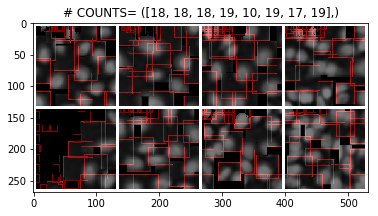

In [31]:
#vae.p_corr_factor = 0.0
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'_rec_both.png')

In [32]:
chosen=7
print(z_where.prob[chosen].view(-1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9999, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0')


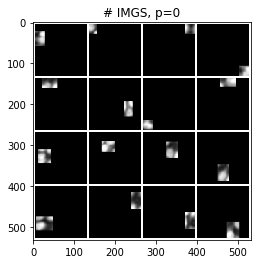

In [33]:
prob_tmp = np.round(z_where.prob[chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
prob_title = 0
b=show_batch(putative_imgs[chosen,:16],nrow=4,npadding=4,title="# IMGS, p="+str(prob_title))
mp.savefig(write_dir+name_vae+'_rec_imgs.png')

DAPI_sigma_each_object_t4_v03_vae


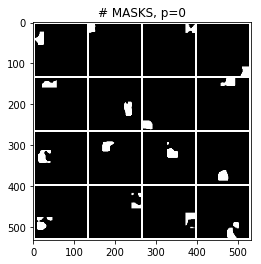

In [34]:
b=show_batch(putative_masks[chosen,:16],nrow=4,npadding=4,title="# MASKS, p="+str(prob_title))
print(name_vae)
mp.savefig(write_dir+name_vae+'_rec_masks.png')

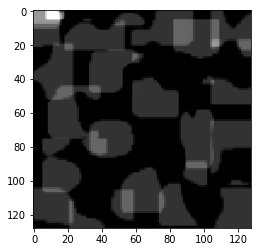

In [35]:
show_batch(torch.sum(putative_masks[chosen],dim=0,keepdim=True))

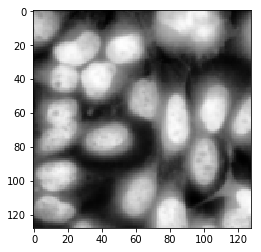

In [36]:
show_batch(reference_imgs[chosen,0][None,None,...])

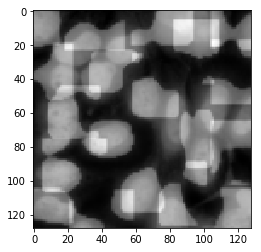

In [37]:
active = (z_where.prob[chosen] > 0.5)[...,None,None].float()
show_batch(torch.sum(active*putative_masks[chosen],dim=0,keepdim=True)+2*reference_imgs[chosen,0])
mp.savefig(write_dir+name_vae+'_debug0_imgs.png')

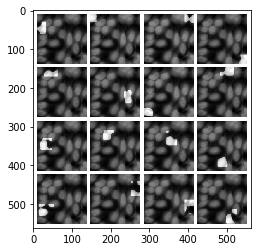

In [38]:
show_batch(putative_masks[chosen,:16]+reference_imgs[chosen,0])
mp.savefig(write_dir+name_vae+'_debug1_imgs.png')

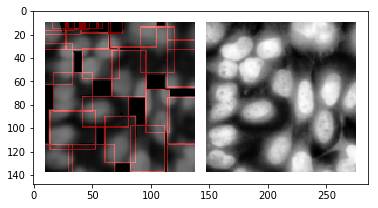

In [39]:
tmp1 = rec_img[chosen].unsqueeze(0)
tmp2 = reference_imgs[chosen].unsqueeze(0).expand(-1,3,-1,-1)
tmp = torch.cat((tmp1,tmp2),dim=0)
show_batch(tmp)
mp.savefig(write_dir+name_vae+'_debug2_imgs.png')

In [40]:
print("reg_small_box ----->",vae.lambda_small_box_size*reg.small_box_size[chosen,:16].detach().cpu())
print("reg_mask_fraction ->",vae.lambda_mask_volume_fraction*reg.mask_volume_fraction[chosen,:16].detach().cpu())
print("reg_mask_absolute ->",vae.lambda_mask_volume_absolute*reg.mask_volume_absolute[chosen,:16].detach().cpu())
print("reg_tot_var ------->",vae.lambda_tot_var_mask*reg.tot_var_mask[chosen,:16].detach().cpu())
print("reg_mask_overlap -->",vae.lambda_overlap*reg.overlap_mask[chosen,:16].detach().cpu())
print("mask_volumes ------>",torch.sum(putative_masks[chosen,:16],dim=(-2,-1)).view(-1))
print("probability object >",z_where.prob[chosen,:16].detach().cpu().view(-1))

reg_small_box -----> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_fraction -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_absolute -> tensor([  7.0490,   0.0000,   0.0000,   0.0000,   0.0000,  50.1045,   0.0000,
         35.3245,  79.6981,   7.0403, 113.2428,   0.9419, 186.0933,   0.0000,
          0.0000,   2.0056])
reg_tot_var -------> tensor([107.7711,  42.8839,  93.6585,  47.8739, 108.6007, 118.4000,  71.4463,
         99.1812, 156.2319, 106.4491, 126.1212, 113.2599, 182.3585,  94.4917,
        118.9048, 155.7545])
reg_mask_overlap --> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
mask_volumes ------> tensor([551.5073, 331.4967, 386.8028, 424.1981, 496.6031, 571.6070, 451.8932,
        581.5756, 637.8741, 539.5116, 571.2123, 550.9572, 633.0649, 379.4341,
        490.6958, 560.5714], device='cuda:0')
probability object > tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000

In [41]:
print("logp_off -------->",logp.logp_off[chosen,:16].detach().cpu())
print("logp_on_cauchy -->",logp.logp_on_cauchy[chosen,:16].detach().cpu())
print("logp_on_normal -->",logp.logp_on_normal[chosen,:16].detach().cpu())
print("probability object",z_where.prob[chosen,:16].detach().cpu().view(-1))

logp_off --------> tensor([-2349.7417,  -612.5593,  -318.3694, -1083.2271, -1047.6534, -1626.9729,
         -773.5096, -1445.0510, -1456.0580, -1656.9611, -1111.5674, -1083.6046,
        -1072.3132,  -200.0737,  -686.7962, -1202.4679])
logp_on_cauchy --> tensor([-1251.2324,   107.8594,   202.6951,    -6.1582,   -52.2028,  -212.6838,
          189.5947,  -113.3109,   -53.1567,  -331.3613,   330.2805,   186.5161,
          377.5184,   277.7610,   185.6235,    -3.8690])
logp_on_normal --> tensor([-263.5734,  749.3243,  932.6688,  679.7261,  798.6743,  943.1691,
         712.2994, 1107.3795,  918.7860,  820.2775, 1383.0975, 1355.6797,
        1443.6270,  952.4921,  935.1863, 1126.7297])
probability object tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Text(0.5, 0, 'Log prob')

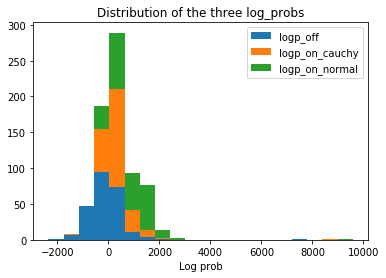

In [42]:
off=logp.logp_off.view(-1).detach().cpu().numpy()
on_c=logp.logp_on_cauchy.view(-1).detach().cpu().numpy()
on_n=logp.logp_on_normal.view(-1).detach().cpu().numpy()
a1 = plt.hist([off,on_c,on_n],bins=20,histtype="bar",stacked=True)
plt.legend(["logp_off","logp_on_cauchy","logp_on_normal"], loc='upper right')
plt.title("Distribution of the three log_probs")
plt.xlabel("Log prob")

# MAKE MOVIE

_0000 0.5
_0005 0.4375
_0010 0.375
_0015 0.3125
_0020 0.25
_0025 0.1875
_0030 0.125
_0035 0.0625
_0040 0.0
_0045 0.0
_0050 0.0
_0055 0.0
_0060 0.0
_0065 0.0
_0070 0.0
_0075 0.0
_0080 0.0
_0085 0.0
_0090 0.0
_0095 0.0
_0100 0.0


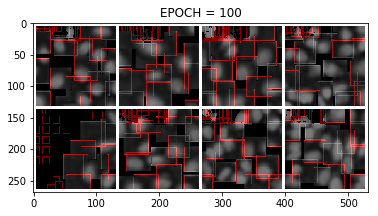

In [43]:
list_of_movie_files = []
for epoch in range(0,105,5):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    else:
        label = str(epoch)
    
    #vae.p_corr_factor = linear_decay_p_factor(epoch,decay_lenght_scale)

    try:
        vae.load_everything(write_dir,name_vae+"_"+str(epoch))
        print(label,vae.p_corr_factor)
        rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
        counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist()
        b=show_batch(rec_img[:8],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
        name_output = name_vae+label+'.png'
        list_of_movie_files.append(name_output)
        mp.savefig(write_dir+name_output) 
    except:
        pass

## Check individual images

In [44]:
#from ipywidgets import interactive, IntSlider
#from PIL import Image
from IPython.display import Image

def show_frame(n):
    return Image(filename=write_dir+list_of_movie_files[n])  
    #image = Image.open(write_dir+list_of_movie_files[n], mode='r')
    #plt.imshow(image)
    #plt.show()    

# Widget does not work
#interactive_plot = interactive(show_frame,n=IntSlider(min=0, max=N_frames-1, step=1))
#output = interactive_plot.children[-1]
#interactive_plot

In [45]:
#write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#name_vae = "MNIST_unit_cauchy_t4_v2_vae_0"
#list_of_movie_files = []
#for file in os.listdir(write_dir):
#    if file.startswith(name_vae) and file.endswith(".png"):
#        list_of_movie_files.append(file)
N_frames = len(list_of_movie_files)
print(list_of_movie_files)
print(N_frames)

['DAPI_sigma_each_object_t4_v03_vae_0000.png', 'DAPI_sigma_each_object_t4_v03_vae_0005.png', 'DAPI_sigma_each_object_t4_v03_vae_0010.png', 'DAPI_sigma_each_object_t4_v03_vae_0015.png', 'DAPI_sigma_each_object_t4_v03_vae_0020.png', 'DAPI_sigma_each_object_t4_v03_vae_0025.png', 'DAPI_sigma_each_object_t4_v03_vae_0030.png', 'DAPI_sigma_each_object_t4_v03_vae_0035.png', 'DAPI_sigma_each_object_t4_v03_vae_0040.png', 'DAPI_sigma_each_object_t4_v03_vae_0045.png', 'DAPI_sigma_each_object_t4_v03_vae_0050.png', 'DAPI_sigma_each_object_t4_v03_vae_0055.png', 'DAPI_sigma_each_object_t4_v03_vae_0060.png', 'DAPI_sigma_each_object_t4_v03_vae_0065.png', 'DAPI_sigma_each_object_t4_v03_vae_0070.png', 'DAPI_sigma_each_object_t4_v03_vae_0075.png', 'DAPI_sigma_each_object_t4_v03_vae_0080.png', 'DAPI_sigma_each_object_t4_v03_vae_0085.png', 'DAPI_sigma_each_object_t4_v03_vae_0090.png', 'DAPI_sigma_each_object_t4_v03_vae_0095.png', 'DAPI_sigma_each_object_t4_v03_vae_0100.png']
21


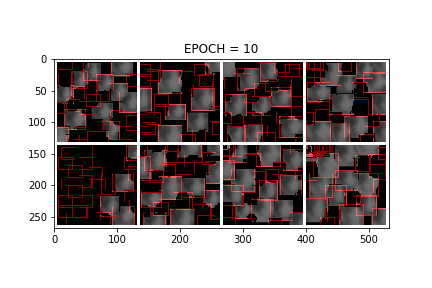

In [46]:
show_frame(2)

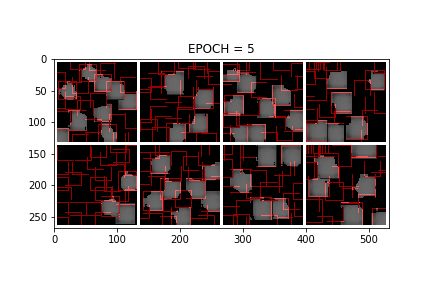

In [47]:
show_frame(1)

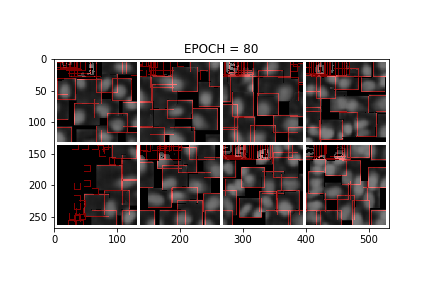

In [48]:
show_frame(16)

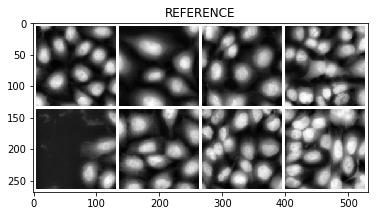

In [49]:
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")